In [ ]:
#imports
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
import shutil
import glob
from PIL import Image
from skimage import color
import pandas as pd
from pathlib import Path
from skimage import io
import numpy as np
from numpy import asarray
from skimage.color import rgb2gray 

#root = "/content/gdrive/My Drive/Rohan Tummala/data"
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


## METRIC FUNCTIONS
metric1 = tf.keras.metrics.Recall()
metric2 = tf.keras.metrics.TruePositives()

bs=30 # Setting batch size
image_size = (180,180)
#train_dir = root + '/Training/' 
#validation_dir = root + '/Testing/'

Mounted at /content/gdrive


In [ ]:
train_data_dir = "/content/gdrive/My Drive/Project Rohan Tummala/data2"

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(180, 180),
    batch_size=30,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=image_size,
    batch_size=bs,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 4763 images belonging to 4 classes.
Found 1189 images belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)
from collections import Counter
counter = Counter(train_generator.classes)
print(counter.items())

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
dict_items([(0, 1297), (1, 460), (2, 1600), (3, 1406)])


In [ ]:
print(validation_generator.class_indices)
from collections import Counter
counter = Counter(validation_generator.classes)
print(counter.items())

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
dict_items([(0, 324), (1, 114), (2, 400), (3, 351)])


In [ ]:
# Parameters
input_shape=(180,180,3)
n_out = 4 # Number of categories for the data
FREEZE_LAYERS = 2 # Freezing layers

In [ ]:
model = InceptionResNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(input_shape))
x = model.output
x = Flatten()(x)
x = Dropout(0.30)(x) # Dropout
output_layer = Dense(n_out, activation='softmax', name='softmax')(x)
net_final = Model(inputs=model.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
# Bring in metric functions
net_final.compile(optimizer=Adam(learning_rate=1e-4), # Learning rate
                  loss='categorical_crossentropy', metrics=['categorical_accuracy',metric1,metric2])

219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
history = net_final.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch = 130 // bs, # Steps
                    epochs=150, # Number of epochs (240 best)
                    validation_steps=50 // bs,
                    verbose=2,
                    workers=8)

Epoch 1/150
4/4 - 86s - loss: 1.4108 - categorical_accuracy: 0.3917 - recall: 0.1917 - true_positives: 23.0000 - val_loss: 2.1760 - val_categorical_accuracy: 0.4000 - val_recall: 0.4000 - val_true_positives: 12.0000 - 86s/epoch - 21s/step
Epoch 2/150
4/4 - 27s - loss: 0.9169 - categorical_accuracy: 0.6500 - recall: 0.5750 - true_positives: 69.0000 - val_loss: 2.4583 - val_categorical_accuracy: 0.4333 - val_recall: 0.4000 - val_true_positives: 12.0000 - 27s/epoch - 7s/step
Epoch 3/150
4/4 - 17s - loss: 0.8326 - categorical_accuracy: 0.7417 - recall: 0.6917 - true_positives: 83.0000 - val_loss: 2.3273 - val_categorical_accuracy: 0.5667 - val_recall: 0.5667 - val_true_positives: 17.0000 - 17s/epoch - 4s/step
Epoch 4/150
4/4 - 18s - loss: 0.9131 - categorical_accuracy: 0.7667 - recall: 0.7417 - true_positives: 89.0000 - val_loss: 1.4647 - val_categorical_accuracy: 0.6667 - val_recall: 0.6667 - val_true_positives: 20.0000 - 18s/epoch - 5s/step
Epoch 5/150
4/4 - 17s - loss: 0.5661 - categori

In [ ]:
def generate_test_data(n_batches):
  validation_generator.reset()
  x_train, y_train = next(validation_generator)
  for i in range(n_batches):
    img, label = next(validation_generator)
    x_train = np.append(x_train, img, axis=0)
    y_train = np.append(y_train, label, axis=0)
  y_pred = net_final.predict(x_train)
  return y_train, y_pred

38/38 [==============================] - 9s 130ms/step


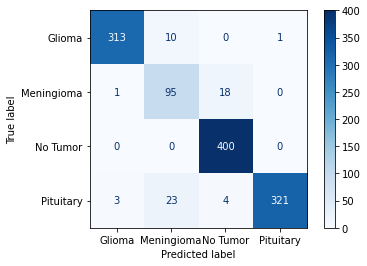

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
y_test, y_pred = generate_test_data(39)
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

dict_keys(['loss', 'categorical_accuracy', 'recall', 'true_positives', 'val_loss', 'val_categorical_accuracy', 'val_recall', 'val_true_positives'])


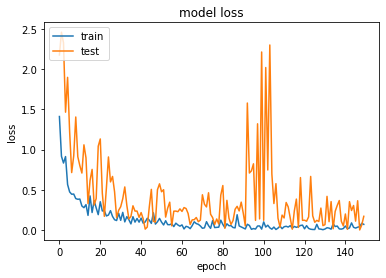

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'categorical_accuracy', 'recall', 'true_positives', 'val_loss', 'val_categorical_accuracy', 'val_recall', 'val_true_positives'])


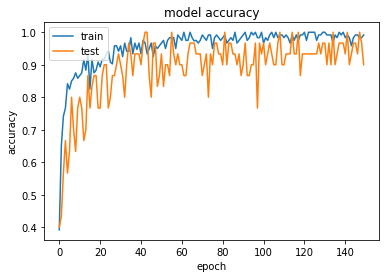

In [ ]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
x_test, y_test = next(validation_generator)
pred = net_final.predict(x_test).round(decimals=2)
classes = list(train_generator.class_indices.keys())

1/1 [==============================] - 0s 50ms/step


Guess: meningioma
Correct: glioma
Model output: [0.16 0.82 0.02 0.01]


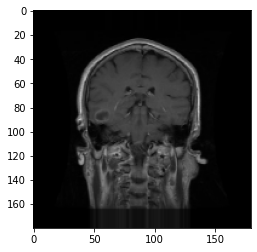

In [ ]:
import matplotlib.pyplot as plt
idx = 6
plt.imshow(x_test[idx])
print("Guess: " + classes[np.argmax(pred[idx])])
print("Correct: " + classes[np.argmax(y_test[idx])])
print("Model output: " + str(pred[idx]))